In [1]:
#Florian's Fib(er)s
%matplotlib notebook
from ipywidgets import *

In [2]:
from sympy.utilities.lambdify import lambdify, implemented_function
from sympy.abc import x
from pylab import *
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import scipy.sparse as sps
import scipy.sparse.linalg as spsla

In [3]:
# Choose here the number of adhesive zones
N=3

In [4]:
L=1.
xi_ini=np.linspace(0,L,2*N)

<IPython.core.display.Javascript object>


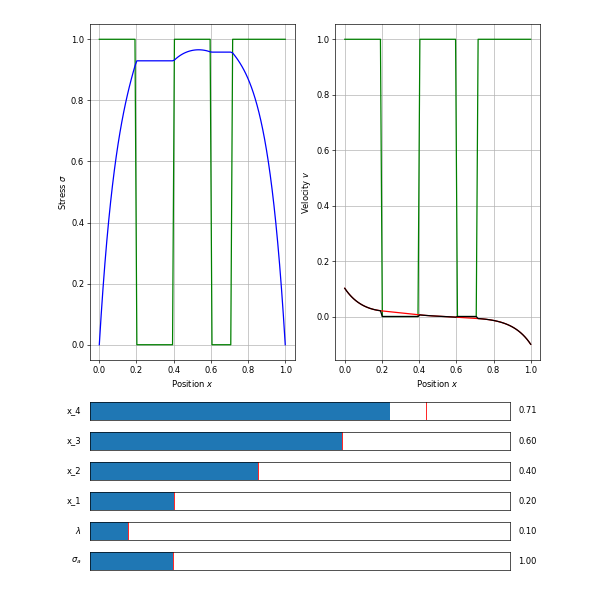

Text(0, 0.5, 'Stress $\\sigma$')

In [5]:
# plot configuration
axis_color = 'lightgoldenrodyellow'
fig = plt.figure(figsize=(10,10))
axvel = fig.add_subplot(1,2,2)
#suptitle('')
fig.subplots_adjust(left=0.15, bottom=0.2+0.05*(2*N-2), top=0.96)
plt.grid(True)
[point]=axvel.plot([0],[0])
xlabel('Position $x$')
ylabel('Velocity $v$')
#Define sliders 
axsiga = axes([0.15, 0.05, 0.70, 0.03]) #, axisbg=axis_color)
axlam = axes([0.15, 0.10, 0.70, 0.03]) #, axisbg=axis_color)
slidsiga = Slider(axsiga, '$\sigma_a$', 0.01, 5.0, valinit=1)
slidlam = Slider(axlam, '$\lambda$', 0.01, 1.0, valinit=0.1)
slaxes = [axsiga, axlam]
sliders = [slidsiga, slidlam]
for i in np.arange(2*N-2):
    slaxes.append(axes([0.15, 0.15+0.05*i, 0.70, 0.03])) #, axisbg='gray'))
    sliders.append(Slider(slaxes[-1], 'x_'+str(i+1), 0., L, valinit=xi_ini[i+1]))
axsig = fig.add_subplot(1,2,1)
plt.grid(True)
xlabel('Position $x$')
ylabel('Stress $\sigma$')

In [6]:
# resolution of model : impose BCs at x=l (get F1 and v1 and then plug in the velocity profiles)
x, y, z, t = symbols('x y z t')
siga, eta, l = symbols('sigma_a eta lambda')
Ap, A, B, Bn, a, b = symbols('A_p A B B_n a b') 
xp, xn = symbols('x_p x_n')

In [7]:
v_odd, v_even = symbols('v_o v_e')

In [8]:
# See scan for details. Here, v defined by v_even(x in [x_2i,x_2i+1],Ai,Bi) or v_odd(x in [x_2i+1,x_2i+2,Ai,Bi+1)
# solves the equations and global continuity of v.
v_odd  = A + (Bn-A)*(x-a)/(b-a)
v_even = A*sinh((x-a)/l)/sinh((b-a)/l) + B*sinh((b-x)/l)/sinh((b-a)/l)
sig_odd = eta*(Bn-A)/(b-a)+siga
sig_even = eta*diff(v_even,x)+siga

In [9]:
#define quick access to these functions
def func_v_odd(the_x,the_A,the_Bn,the_l,the_a,the_b):
    return v_odd.subs({A:the_A,Bn:the_Bn,l:the_l,x:the_x,a:the_a,b:the_b})
eval_v_odd = lambdify((x,A,Bn,l,a,b), func_v_odd(x,A,Bn,l,a,b), modules=['numpy'])

In [10]:
def func_v_even(the_x,the_A,the_B,the_l,the_a,the_b):
        return v_even.subs({A:the_A,B:the_B,l:the_l,x:the_x,a:the_a,b:the_b})
eval_v_even = lambdify((x,A,B,l,a,b), func_v_even(x,A,B,l,a,b), modules=['numpy'])

In [11]:
def func_sig_odd(the_x,the_A,the_Bn,the_l,the_eta,the_siga,the_a,the_b):
    return sig_odd.subs({A:the_A,Bn:the_Bn,l:the_l,eta:the_eta,siga:the_siga,x:the_x,a:the_a,b:the_b})
eval_sig_odd = lambdify((x,A,Bn,l,eta,siga,a,b), func_sig_odd(x,A,Bn,l,eta,siga,a,b), modules=['numpy'])

In [12]:
def func_sig_even(the_x,the_A,the_B,the_l,the_eta,the_siga,the_a,the_b):
        return sig_even.subs({A:the_A,B:the_B,l:the_l,eta:the_eta,siga:the_siga,x:the_x,a:the_a,b:the_b})
eval_sig_even = lambdify((x,A,B,l,eta,siga,a,b), func_sig_even(x,A,B,l,eta,siga,a,b), modules=['numpy'])

In [13]:
def friction(the_x,xi):
    ii=np.searchsorted(xi,the_x)-1
    v=np.zeros_like(the_x)
    m=0
    for i in ii:
        if (i==-1):
            i=0
        if (i%2==1):
            v[m]= 0
        else:
            v[m]= 1
        m=m+1
    return v

In [14]:
def velocity(the_x,xi,U,the_l):
    ii=np.searchsorted(xi,the_x)-1
    v=np.zeros_like(the_x)
    m=0
    for i in ii:
        if (i==-1):
            i=0 
        if (i%2==1):
            v[m]= eval_v_odd(the_x[m],U[i],U[i+1],the_l,xi[i],xi[i+1])
        else:
            v[m]= eval_v_even(the_x[m],U[i+1],U[i],the_l,xi[i],xi[i+1])
        m=m+1
    return v

In [15]:
def traction(the_x,xi,U,the_l):
    ii=np.searchsorted(xi,the_x)-1
    v=np.zeros_like(the_x)
    m=0
    for i in ii:
        if (i==-1):
            i=0 
        if (i%2==1):
            v[m]= 0
        else:
            v[m]= eval_v_even(the_x[m],U[i+1],U[i],the_l,xi[i],xi[i+1])
        m=m+1
    return v

In [16]:
def sigma(the_x,xi,U,the_l,the_eta,the_siga):
    ii=np.searchsorted(xi,the_x)-1
    v=np.zeros_like(the_x)
    m=0
    for i in ii:
        if (i==-1):
            i=0 
        if (i%2==1):
            v[m]= eval_sig_odd(the_x[m],U[i],U[i+1],the_l,the_eta,the_siga,xi[i],xi[i+1])
        else:
            v[m]= eval_sig_even(the_x[m],U[i+1],U[i],the_l,the_eta,the_siga,xi[i],xi[i+1])
        m=m+1
    return v

In [17]:
# Condition on the left/right
eq_0=expand((diff(v_even,x).subs({a:x,b:xn})-siga/eta))
eq_2Nmin1=expand(diff(v_even,x).subs({a:xp,b:x})-siga/eta)

In [18]:
# Midpoints: equilibration of the stress
eq_odd  =expand(diff(v_even,x).subs({a:xp,b:x}) - diff(v_odd,x).subs({a:x,b:xn}))
eq_even =expand(diff(v_odd,x).subs({a:xp,b:x,A:Ap,Bn:B}) - diff(v_even,x).subs({a:x,b:xn}))

In [19]:
pprint(eq_0)
pprint(eq_odd)
pprint(eq_even)
pprint(eq_2Nmin1)

                         ⎛  x   xₙ⎞     
                   B⋅cosh⎜- ─ + ──⎟     
       A                 ⎝  λ   λ ⎠   σₐ
──────────────── - ──────────────── - ──
      ⎛  x   xₙ⎞         ⎛  x   xₙ⎞   η 
λ⋅sinh⎜- ─ + ──⎟   λ⋅sinh⎜- ─ + ──⎟     
      ⎝  λ   λ ⎠         ⎝  λ   λ ⎠     
                ⎛x   xₚ⎞                           
          A⋅cosh⎜─ - ──⎟                           
   A            ⎝λ   λ ⎠         B             Bₙ  
─────── + ────────────── - ────────────── - ───────
-x + xₙ         ⎛x   xₚ⎞         ⎛x   xₚ⎞   -x + xₙ
          λ⋅sinh⎜─ - ──⎟   λ⋅sinh⎜─ - ──⎟          
                ⎝λ   λ ⎠         ⎝λ   λ ⎠          
                                             ⎛  x   xₙ⎞
                                       B⋅cosh⎜- ─ + ──⎟
         A             Aₚ       B            ⎝  λ   λ ⎠
- ──────────────── - ────── + ────── + ────────────────
        ⎛  x   xₙ⎞   x - xₚ   x - xₚ         ⎛  x   xₙ⎞
  λ⋅sinh⎜- ─ + ──⎟                     λ⋅sinh⎜- ─ + ──⎟
        ⎝  λ 

In [20]:
def assemble(xi, the_l, the_eta, the_siga):
    # 0=lower diag, 1=diag, 2=upper diag
    to_upper=1
    to_lower=-1
    N=int(np.floor(len(xi)/2))
    diags = np.zeros((3,2*N))
    Diags = MutableDenseNDimArray(np.zeros(3*2*N),(3,2*N))
    rhs   = np.zeros(2*N)
    the_x=0.
    the_xn=xi[1]
    diags[1,0]=eq_0.coeff(B).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xn:the_xn})
    Diags[1,0]=eq_0.coeff(B)
    diags[1+to_upper,0+to_upper]=eq_0.coeff(A).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xn:the_xn})
    Diags[1+to_upper,0+to_upper]=eq_0.coeff(A)
    rhs[0]=(eq_0-eq_0.coeff(A)*A-eq_0.coeff(B)*B).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xn:the_xn})
    for i in np.arange(0,N-1):
        the_xp=the_x
        the_x=the_xn
        the_xn=xi[2*i+2]
        diags[1,2*i+1]=eq_odd.coeff(A).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1,2*i+1]=eq_odd.coeff(A)
        diags[1+to_upper,2*i+1+to_upper]=eq_odd.coeff(Bn).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1+to_upper,2*i+1+to_upper]=eq_odd.coeff(Bn)
        diags[1+to_lower,2*i+1+to_lower]=eq_odd.coeff(B).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1+to_lower,2*i+1+to_lower]=eq_odd.coeff(B)
        the_xp=the_x
        the_x=the_xn
        the_xn=xi[2*i+3]
        diags[1,2*i+2]=eq_even.coeff(B).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1,2*i+2]=eq_even.coeff(B)
        diags[1+to_upper,2*i+2+to_upper]=eq_even.coeff(A).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1+to_upper,2*i+2+to_upper]=eq_even.coeff(A)
        diags[1+to_lower,2*i+2+to_lower]=eq_even.coeff(Ap).subs({l:the_l,eta:the_eta,siga:the_siga,xp:the_xp,x:the_x,xn:the_xn})
        Diags[1+to_lower,2*i+2+to_lower]=eq_even.coeff(Ap)
    the_xp=the_x
    the_x=the_xn
    the_xn=xi[2*N-1]
    diags[1,2*N-1]=eq_2Nmin1.coeff(A).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xp:the_xp})
    Diags[1,2*N-1]=eq_2Nmin1.coeff(A)
    diags[1+to_lower,2*N-1+to_lower]=eq_2Nmin1.coeff(B).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xp:the_xp})
    Diags[1+to_lower,2*N-1+to_lower]=eq_2Nmin1.coeff(B)
    rhs[2*N-1]=(eq_2Nmin1-eq_2Nmin1.coeff(A)*A-eq_2Nmin1.coeff(B)*B).subs({l:the_l,eta:the_eta,siga:the_siga,x:the_x,xp:the_xp})
    #pprint(Diags)
    return (sps.dia_matrix((diags,[-1,0,1]),shape=(2*N,2*N)), rhs)

In [21]:
def solve(xi,l,eta,siga):
    Lambda,b=assemble(xi,l,eta,siga)
    L2=Lambda.astype(np.float64)
    U = spsla.dsolve.spsolve(L2, b, use_umfpack=True)
    return U

In [22]:
xii = np.linspace(0, L, 100)

In [23]:
subplot(1,2,2)
[frics]=axsig.plot(xii,friction(xii,xi_ini),color='g')
[sig]=axsig.plot(xii,sigma(xii,xi_ini,solve(xi_ini,slidlam.val,1,slidsiga.val),slidlam.val,1,slidsiga.val),color='b')
subplot(1,2,1)
[fricv]=axvel.plot(xii,friction(xii,xi_ini),color='g')
[vel]=axvel.plot(xii,velocity(xii,xi_ini,solve(xi_ini,slidlam.val,1,slidsiga.val),slidlam.val),color='r')
[trac]=axvel.plot(xii,traction(xii,xi_ini,solve(xi_ini,slidlam.val,1,slidsiga.val),slidlam.val),color='k')

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """Entry point for launching an IPython kernel.
/home/etienne/.local/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes 

In [24]:
def update_xi(val):
        new_xi=[0]
        for i in np.arange(2*N-2):
            if (sliders[i+2].val<new_xi[-1]):
                sliders[i+2].set_val(new_xi.pop())
            elif (sliders[i+2].val==new_xi[-1]):
                new_xi.pop()
            else:
                new_xi.append(sliders[i+2].val)
        new_xi.append(L)
        xi=np.array(new_xi)
        return xi

In [25]:
def update_and_redraw(val):
        xi=update_xi(val)
        frics.set_ydata(friction(xii,xi))
        fricv.set_ydata(friction(xii,xi))
        U=solve(xi,slidlam.val,1,slidsiga.val)
        vel.set_ydata(velocity(xii,xi,U,slidlam.val))
        trac.set_ydata(traction(xii,xi,U,slidlam.val))
        sig.set_ydata(sigma(xii,xi,U,slidlam.val,1,slidsiga.val))
        draw()

Plot solutions with initial parameters
plt.legend()

In [26]:
for sl in sliders:
    sl.on_changed(update_and_redraw)

In [27]:
show()